In [1]:
#@title Try my epitope
import json, time, os, sys, glob

In [2]:
#@title Setup Model
import matplotlib.pyplot as plt
import shutil
import warnings
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model_name = "128_earlystop" 

In [4]:
print(device)
print(os.getcwd())

cpu
C:\Users\JIY106\OneDrive - University of Pittsburgh\Publications\Redesign\Github\testing


In [5]:
#seed=int(np.random.randint(0, high=999, size=1, dtype=int)[0]) #write by my own
seed = 37
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [6]:
backbone_noise=0.0           # Standard deviation of Gaussian noise to add to backbone atoms

In [7]:
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

Current working directory: C:\Users\JIY106\OneDrive - University of Pittsburgh\Publications\Redesign\Github\testing


In [8]:
path_to_model_weights='.'          
hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

In [9]:
checkpoint = torch.load(checkpoint_path, map_location=device) 
print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'])
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

C:\Users\JIY106\AppData\Local\Temp\ipykernel_20192\3578183430.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

Number of edges: 48
Training noise level: 0A
Model loaded


In [10]:
#@title Helper functions
def make_tied_positions_for_homomers(pdb_dict_list):
    my_dict = {}
    for result in pdb_dict_list:
        all_chain_list = sorted([item[-1:] for item in list(result) if item[:9]=='seq_chain']) #A, B, C, ...
        tied_positions_list = []
        chain_length = len(result[f"seq_chain_{all_chain_list[0]}"])
        for i in range(1,chain_length+1):
            temp_dict = {}
            for j, chain in enumerate(all_chain_list):
                temp_dict[chain] = [i] #needs to be a list
            tied_positions_list.append(temp_dict)
        my_dict[result['name']] = tied_positions_list
    return my_dict

In [11]:
import re
import numpy as np
import pathlib
import pandas as pd

In [12]:
def get_pdb(pdb_code=""):
    if pdb_code is None or pdb_code == "":
        upload_dict = files.upload()
        pdb_string = upload_dict[list(upload_dict.keys())[0]]
        with open("tmp.pdb","wb") as out: out.write(pdb_string)
        return "tmp.pdb"
    else:
        os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
        return f"{pdb_code}.pdb"

In [15]:
data_for_csv = []
pdb_directory = 'sample_data'
pdb_files = [file for file in os.listdir(pdb_directory) if file.endswith('.pdb')]
print(len(pdb_files))
for pdb in os.listdir(pdb_directory):
    if pdb.endswith('.pdb'):
        pdb_path = os.path.join(pdb_directory, pdb)
        print(pdb_path)
    homomer = False #@param {type:"boolean"} #Input
    designed_chain = "A" #@param {type:"string"} #Input
    fixed_chain = "" #@param {type:"string"} #Input
    if designed_chain == "":
        designed_chain_list = []
    else:
        designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

    if fixed_chain == "":
        fixed_chain_list = []
    else:
        fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

    chain_list = list(set(designed_chain_list + fixed_chain_list))
    num_seqs = 4 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"} #Input
    num_seq_per_target = num_seqs

    #@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.
    sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"] #Input
    save_score=1                      # 0 for False, 1 for True; save score=-log_prob to npy files
    save_probs=1                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
    score_only=1                      # 0 for False, 1 for True; score input backbone-sequence pairs
    conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
    conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
    batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
    max_length=20000                  # Max sequence length
    
    out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
    jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
    omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
    pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
    pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
    pssm_log_odds_flag=0               # 0 for False, 1 for True
    pssm_bias_flag=0                   # 0 for False, 1 for True
    folder_for_outputs = out_folder

    NUM_BATCHES = num_seq_per_target//batch_size
    BATCH_COPIES = batch_size
    temperatures = [float(item) for item in sampling_temp.split()]
    omit_AAs_list = omit_AAs
    alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
    omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

    chain_id_dict = None #Optional Input
    fixed_positions_dict = None
    #fixed_positions_dict = {'4y19':{'C': [3,4,5,6,7,8]}} #fix position 2,4,6,7.#The first amino acid in the chain corresponds to 1 and not PDB residues index for now
    pssm_dict = None
    omit_AA_dict = None
    bias_AA_dict = None
    tied_positions_dict = None
    bias_by_res_dict = None
    bias_AAs_np = np.zeros(len(alphabet))
    pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list) #If want ca_only, then add this tag
    dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

    chain_id_dict = {}
    chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)
    all_chain_list = [item[-1:] for item in list(pdb_dict_list[0]) if item[:9]=='seq_chain']

    print(chain_id_dict)
    for chain in chain_list:
        l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
        #print(f"Length of chain {chain} is {l}")

    if homomer:
        tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
    else:
        tied_positions_dict = None
    #@title RUN
    __file__ = get_pdb(pdb)
    start_time = time.time() #initialize some variables
    total_residues = 0
    protein_list = []
    total_step = 0
    #enter a validation epoch
    with torch.no_grad():
        print('Generating sequences...')
    for ix, protein in enumerate(dataset_valid):
        score_list = []
        global_score_list = []
        all_probs_list = []
        all_log_probs_list = []
        S_sample_list = []
        batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
        #featurize the node features:
        X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
        pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
        name_ = batch_clones[0]['name']

        randn_1 = torch.randn(chain_M.shape, device=X.device) #if not score_only function
        log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
        mask_for_loss = mask*chain_M*chain_M_pos
        scores = _scores(S, log_probs, mask_for_loss) #score the redesign part
        native_score = scores.cpu().data.numpy()
        global_scores = _scores(S, log_probs, mask) #score the whole structure-sequence
        global_native_score = global_scores.cpu().data.numpy()

        t0 = time.time()
    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"] 
            else:
                sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()

            global_scores = _scores(S_sample, log_probs, mask) #score the whole structrue-sequence
            global_scores = global_scores.cpu().data.numpy()

            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                score = scores[b_ix]
                score_list.append(score)
                global_score = global_scores[b_ix]
                global_score_list.append(global_score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    global_native_score_print = np.format_float_positional(np.float32(global_native_score.mean()), unique=False, precision=4)
                    IEDBID = name_.split('\\')[1]
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}, seed={}\n{}\n'.format(IEDBID, native_score_print, print_visible_chains, print_masked_chains, model_name, seed, native_seq)
                    #print(line.rstrip())
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                global_score_print = np.format_float_positional(np.float32(global_score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                sample_number = j*BATCH_COPIES+b_ix+1
                line = '>T={}, sample={}, score={}, global_score={}, seq_recovery={}\n{}\n'.format(temp,sample_number,score_print,global_score_print, seq_rec_print,seq)
                #print(line.rstrip())
                iedb_id_csv = IEDBID
                seq_csv = seq
                seq_rec_csv = seq_rec_print
                data_for_csv.append({
                "IEDBID": iedb_id_csv,
                "sequences": seq_csv,
                "sequence recovery": seq_rec_csv,
                })
    all_probs_concat = np.concatenate(all_probs_list)
    all_log_probs_concat = np.concatenate(all_log_probs_list)
    S_sample_concat = np.concatenate(S_sample_list)
    t1 = time.time()
    dt = round(float(t1-t0), 4)
    num_seqs = len(temperatures)*NUM_BATCHES*BATCH_COPIES
    total_length = X.shape[1]
    df = pd.DataFrame(data_for_csv)
    output_csv_path = "output_sequences_sample_data.csv"
    df.to_csv(output_csv_path, index=False)

10
sample_data\191.pdb
{'sample_data\\191': (['A'], [])}
Generating sequences...
sample_data\258.pdb
{'sample_data\\258': (['A'], [])}
Generating sequences...
sample_data\292.pdb
{'sample_data\\292': (['A'], [])}
Generating sequences...
sample_data\344.pdb
{'sample_data\\344': (['A'], [])}
Generating sequences...
sample_data\352.pdb
{'sample_data\\352': (['A'], [])}
Generating sequences...
sample_data\522.pdb
{'sample_data\\522': (['A'], [])}
Generating sequences...
sample_data\798.pdb
{'sample_data\\798': (['A'], [])}
Generating sequences...
sample_data\845.pdb
{'sample_data\\845': (['A'], [])}
Generating sequences...
sample_data\885.pdb
{'sample_data\\885': (['A'], [])}
Generating sequences...
sample_data\93.pdb
{'sample_data\\93': (['A'], [])}
Generating sequences...


In [16]:
#output csv only contains the redesigned sequences, do not include the original input sequence.
df = pd.read_csv('output_sequences_sample_data.csv')
average_recovery = df.groupby('IEDBID')['sequence recovery'].mean().reset_index()
average_recovery.rename(columns={'sequence recovery': 'average sequence recovery'}, inplace=True)
print(average_recovery)
average_recovery.to_csv('average_sequence_recovery_sample_data.csv', index=False)

   IEDBID  average sequence recovery
0      93                   0.616675
1     191                   0.640000
2     258                   0.850025
3     292                   0.739575
4     344                   0.825000
5     352                   0.500000
6     522                   0.687500
7     798                   0.637500
8     845                   0.900000
9     885                   0.575000


In [17]:
print(os.getcwd())

C:\Users\JIY106\OneDrive - University of Pittsburgh\Publications\Redesign\Github\testing


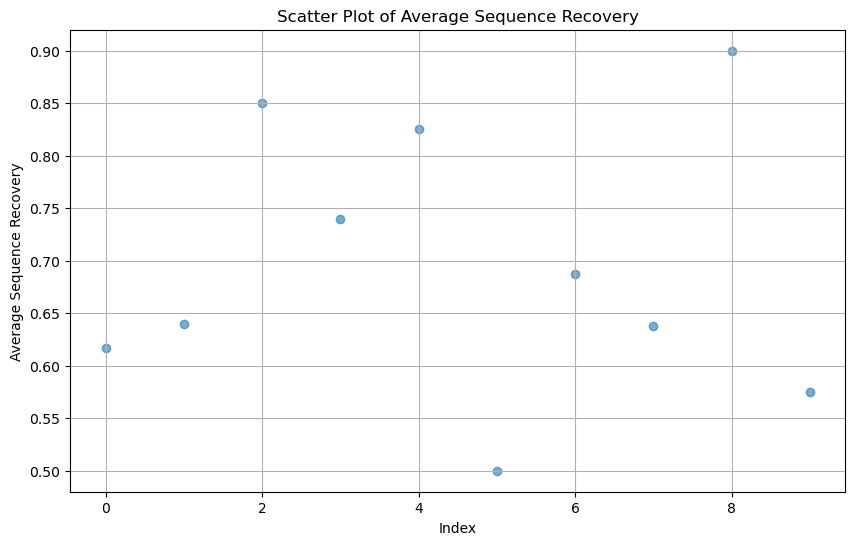

Mean average sequence recovery: 0.6971275
Median average sequence recovery: 0.6637500000000001
Standard Deviation of average sequence recovery: 0.12903346866112772
Min average sequence recovery: 0.5
Max average sequence recovery: 0.9


In [18]:
df = pd.read_csv('average_sequence_recovery_sample_data.csv')
stats = df['average sequence recovery'].describe()

plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['average sequence recovery'], alpha=0.6)
plt.title('Scatter Plot of Average Sequence Recovery')
plt.xlabel('Index')
plt.ylabel('Average Sequence Recovery')
plt.grid(True)

# Save the figure
plt.savefig('average_sequence_recovery_plot_sample_data.png', dpi=300)  # Adjust dpi for higher resolution

plt.show()

mean_recovery = df['average sequence recovery'].mean()
median_recovery = df['average sequence recovery'].median()
std_recovery = df['average sequence recovery'].std()
min_recovery = df['average sequence recovery'].min()
max_recovery = df['average sequence recovery'].max()
print(f"Mean average sequence recovery: {mean_recovery}")
print(f"Median average sequence recovery: {median_recovery}")
print(f"Standard Deviation of average sequence recovery: {std_recovery}")
print(f"Min average sequence recovery: {min_recovery}")
print(f"Max average sequence recovery: {max_recovery}")